In [1]:
import pandas as pd 
import pandasql as ps
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime
from scipy.stats import ttest_ind, chi2_contingency
import warnings
warnings.filterwarnings('ignore')

In [2]:
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 90% !important; }</style>"))

# Load Data

In [3]:
## Load dataset (Specify file name)
target_dir = 'data'
target_file = 'frvr-businesscase-dataset-3-.csv'
target_file_path = os.path.join(target_dir, target_file)

## Load dataset
frvr_user_events_raw = pd.read_csv(target_file_path, delimiter = ',')

## Drop duplicates
frvr_user_events_raw = frvr_user_events_raw.drop_duplicates()


# Add useful new columns
frvr_user_events_raw['acquisition_date'] = pd.to_datetime(frvr_user_events_raw['acquisition_date'])
frvr_user_events_raw['date'] = pd.to_datetime(frvr_user_events_raw['date'])
frvr_user_events_raw['days_since_acquisition'] = (frvr_user_events_raw['date'] - frvr_user_events_raw['acquisition_date']).dt.days

## Read first 3 rows
frvr_user_events_raw.head(3)

,user_id,acquisition_date,date,is_acquired,ab_group,ad_revenue,ad_revenue_interstitial,ad_revenue_rewarded,ad_impressions_interstitial,ad_impressions_rewarded,days_since_acquisition
0,2788165294615712,2022-10-09,2022-10-13,False,test_group,0.0,0.0,0.0,0,0,4
1,5793823020638738,2022-10-17,2022-10-17,False,control_group,0.0,0.0,0.0,0,0,0
2,5140934416008790,2022-10-16,2022-10-16,False,control_group,0.0,0.0,0.0,0,0,0


# 2. A/B Test Analysis – Business Decision Making

**Task:**

Compare the **Control Group vs. Test Group** based on:

- **Retention and revenue metrics**
- Apply **statistical tests** (e.g., t-test, chi-square) to determine whether the test group can result in a revenue increase **without negatively impacting user experience**.

**Expected Output:**

- Python or R script
- Any additional insights

## 2. Statistical Tests

#### a) Create functions to build dataset, run statistical tests & visualise results

In [4]:
def create_abtest_df_sql(data = None, days=None):
    query = f"""
    with frvr_users as (
        select 
              user_id
            , ab_group
            , acquisition_date
            , date as event_date
            , '2022-10-21' as max_date
            , julianday(date) - julianday(acquisition_date) as days_between_event_and_acquisition
            , julianday('2022-10-21') - julianday(acquisition_date) as maximum_possible_days_active
            , sum(ad_impressions_interstitial) ad_impressions_interstitial
            , sum(ad_impressions_rewarded) as ad_impressions_rewarded
            , sum(ad_impressions_interstitial) + sum(ad_impressions_rewarded) as ad_impressions_total
            , sum(ad_revenue) as ad_revenue
        from data
        group by 1,2,3,4,5,6,7
    ),
    frvr_users_agg as (
        select
              user_id
            , acquisition_date
            , event_date
            , ab_group
            , days_between_event_and_acquisition
            , maximum_possible_days_active
            , sum(ad_revenue) over (partition by user_id order by event_date asc) as ad_revenue_cumulative
        from frvr_users
        where days_between_event_and_acquisition <= {days}
            and maximum_possible_days_active >= {days}
    ),
    frvr_users_agg_final as (
        select
              *
            , case when days_between_event_and_acquisition = {days} then 1 else 0 end as flag_retained
            , rank() over (partition by user_id order by event_date desc) as rank
        from frvr_users_agg
    )
    select * from frvr_users_agg_final where rank = 1
    
        """
    
    df = ps.sqldf(query, locals())

    return df

def run_stat_test_chi_square(data, metric_column_name = None):

    df = data
    
    # Create contingency table
    contingency_table = pd.crosstab(df['ab_group'], df[metric_column_name])

    # Run chi-square test
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

    result = {
          'chi2_statistic': round(float(chi2_stat),3)
        , 'p_value': round(float(p_value),3)
        , 'significance': 'Not-Significant' if p_value > 0.05 else ('Very-Significant' if p_value <= 0.01 else 'Significant')
    }
    
    return result


def run_stat_test_ind_ttest(data, metric_column_name = None):

    # Create data for control_group & test_group
    control_group = data[data['ab_group'] == 'control_group'][metric_column_name]
    test_group = data[data['ab_group'] == 'test_group'][metric_column_name]
    
    # Run independent t-test
    t_stat, p_value = ttest_ind(control_group, test_group, equal_var=False)

    result = {
          't-statistic': round(float(t_stat),3)
        , 'p_value': round(float(p_value),3)
        , 'significance': 'Not-Significant' if p_value > 0.05 else ('Very-Significant' if p_value <= 0.01 else 'Significant')
    }
    
    return result    


def visualise_arpu(data, kpi_name = None, y_axis_max_value = None):

    df = data
    df = df.groupby('ab_group').agg({'user_id':'nunique', 'ad_revenue_cumulative':'sum'}).reset_index()
    df[kpi_name] = df['ad_revenue_cumulative'] / df['user_id']

    # Define y-ticks
    yticks = np.arange(0, y_axis_max_value, 0.05) 
    ytick_labels = [f"${x:.2f}" for x in yticks] 

    # Plotting
    plt.figure(figsize=(4, 6))
    bars = plt.bar(df['ab_group'], df[kpi_name], color=['steelblue', 'seagreen'])
    
    # Y-axis formatting in dollars
    plt.ylabel(f"{kpi_name}", fontsize=12)
    plt.title(f"{kpi_name}", fontsize=14)
    plt.ylim(0, yticks[-1])
    plt.yticks(yticks, ytick_labels)  # <- clean fix: set both ticks and ticklabels
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"${height:.2f}", ha='center', fontsize=11)

    plt.tight_layout()
    plt.show()
    print('')
    print(df.set_index('ab_group'))
    



def visualise_retention_rate(data, kpi_name = None, y_axis_max_value = None):

    df = data
    df = df.groupby('ab_group').agg({'user_id':'nunique', 'flag_retained':'sum'}).reset_index()
    df[kpi_name] = df['flag_retained'] / df['user_id']
    

    # Define y-ticks
    yticks = np.arange(0, y_axis_max_value, 0.005) 
    ytick_labels = [f"{x:.2%}" for x in yticks]

    # Plotting
    plt.figure(figsize=(4,6))
    bars = plt.bar(df['ab_group'], df[kpi_name], color=['steelblue', 'seagreen'])
    
    # Y-axis formatting in dollars
    plt.ylabel(f"{kpi_name}", fontsize=12)
    plt.title(f"{kpi_name}", fontsize=14)
    plt.ylim(0, yticks[-1])
    plt.yticks(yticks, ytick_labels)  # <- clean fix: set both ticks and ticklabels
    
    # Add value labels
    for bar in bars:
        values = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, values + 0.005, f"{values*100:.2f}%", ha='center', fontsize=11)
    
    plt.tight_layout()
    plt.show()
    print(df.set_index('ab_group'))

#### b) Retention & Revenue Statistical Analysis [D7]

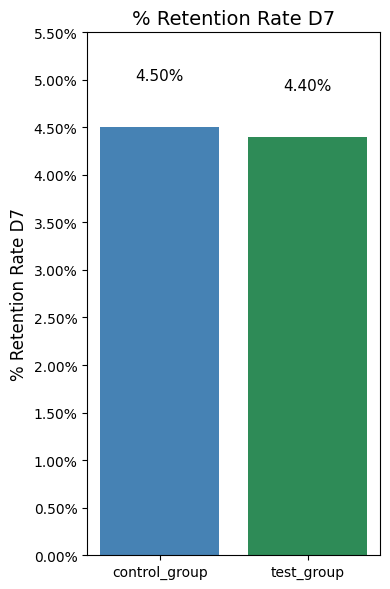

               user_id  flag_retained  % Retention Rate D7
ab_group                                                  
control_group    24914           1122             0.045035
test_group       25140           1105             0.043954


{'chi2_statistic': 0.319, 'p_value': 0.572, 'significance': 'Not-Significant'}


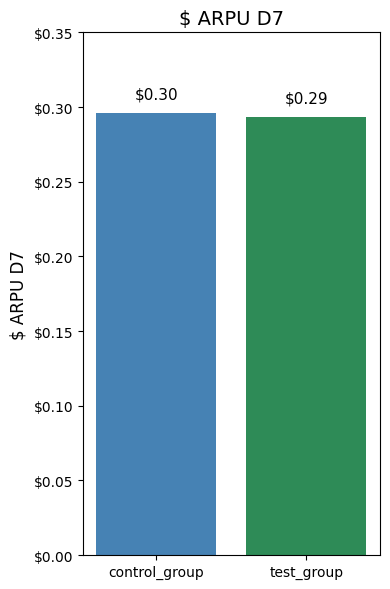


               user_id  ad_revenue_cumulative  $ ARPU D7
ab_group                                                
control_group    24914            7375.263415   0.296029
test_group       25140            7372.295622   0.293250


{'t-statistic': 0.228, 'p_value': 0.82, 'significance': 'Not-Significant'}


In [5]:
## Create dataset (7-days)
result_ab_test_d7 = create_abtest_df_sql(data = frvr_user_events_raw, days=7)

## Retention Metrics
stat_test_retention_rate = run_stat_test_chi_square(data=result_ab_test_d7, metric_column_name = 'flag_retained')
visualise_retention_rate(data=result_ab_test_d7, kpi_name = '% Retention Rate D7', y_axis_max_value = 0.06)
print('')
print('')
print(stat_test_retention_rate)


## ARPU Metrics
stat_test_arpu = run_stat_test_ind_ttest(data=result_ab_test_d7, metric_column_name = 'ad_revenue_cumulative')
visualise_arpu(data=result_ab_test_d7, kpi_name  = '$ ARPU D7', y_axis_max_value = 0.4)
print('')
print('')
print(stat_test_arpu)

#### b) Retention & Revenue Statistical Analysis [D3]

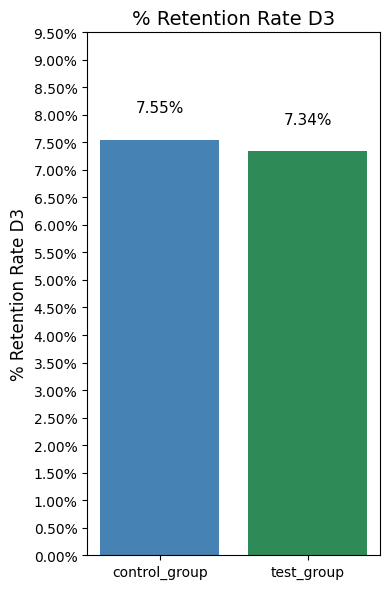

               user_id  flag_retained  % Retention Rate D3
ab_group                                                  
control_group    36784           2776             0.075468
test_group       37079           2720             0.073357


{'chi2_statistic': 1.164, 'p_value': 0.281, 'significance': 'Not-Significant'}


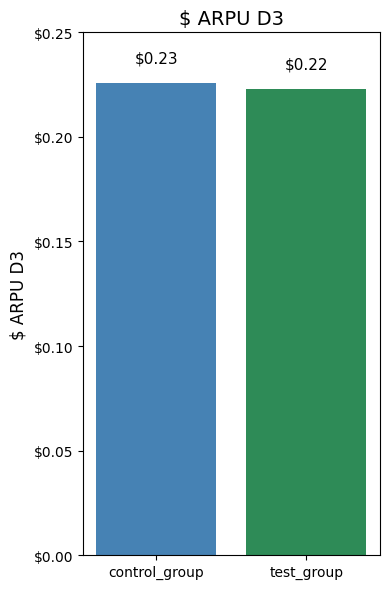


               user_id  ad_revenue_cumulative  $ ARPU D3
ab_group                                                
control_group    36784            8304.605736   0.225767
test_group       37079            8264.093072   0.222878


{'t-statistic': 0.421, 'p_value': 0.673, 'significance': 'Not-Significant'}


In [6]:
## Create dataset (3-days)
result_ab_test_d3 = create_abtest_df_sql(data = frvr_user_events_raw, days=3)

## Retention Metrics
stat_test_retention_rate = run_stat_test_chi_square(data=result_ab_test_d3, metric_column_name = 'flag_retained')
visualise_retention_rate(data=result_ab_test_d3, kpi_name = '% Retention Rate D3', y_axis_max_value = 0.1)
print('')
print('')
print(stat_test_retention_rate)


## ARPU Metrics
stat_test_arpu = run_stat_test_ind_ttest(data=result_ab_test_d3, metric_column_name = 'ad_revenue_cumulative')
visualise_arpu(data=result_ab_test_d3, kpi_name  = '$ ARPU D3', y_axis_max_value = 0.3)
print('')
print('')
print(stat_test_arpu)